In [5]:
import scipy.io as sio
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score
import numpy as np
from sleepdetector import Sleepdetector

# Load Data File
filepath = './data/data.mat'
mat_file = sio.loadmat(filepath)
n_examples = np.shape(mat_file['sig1'])[0]
x = np.zeros((4, n_examples, 3000, 1))
x[0] = mat_file['sig1']
x[1] = mat_file['sig2']
x[2] = mat_file['sig3']
x[3] = mat_file['sig4']

# Load CRNNeeg
weights_cnn_path = 'cnn_weights.hdf5'
weights_lstm_path = 'lstm_weights.h5'
CRNNeeg = Sleepdetector(cnn_path=weights_cnn_path, lstm_path=weights_lstm_path)

# Predict Sleep Stages
y_hat = CRNNeeg.predict(x)

if isinstance(y_hat, int) and y_hat == -1:
    print("Error in prediction. Check input dimensions.")
else:
    

    # Compute Cohen's Kappa and Accuracy
    ck = cohen_kappa_score(y_true, y_hat)
    accuracy = accuracy_score(y_true, y_hat)

    print("Cohen's Kappa = %0.3f" % (ck))
    print("Accuracy = %0.4f %%" % (100*accuracy))

Cohen's Kappa = 0.693
Accuracy = 76.7578 %


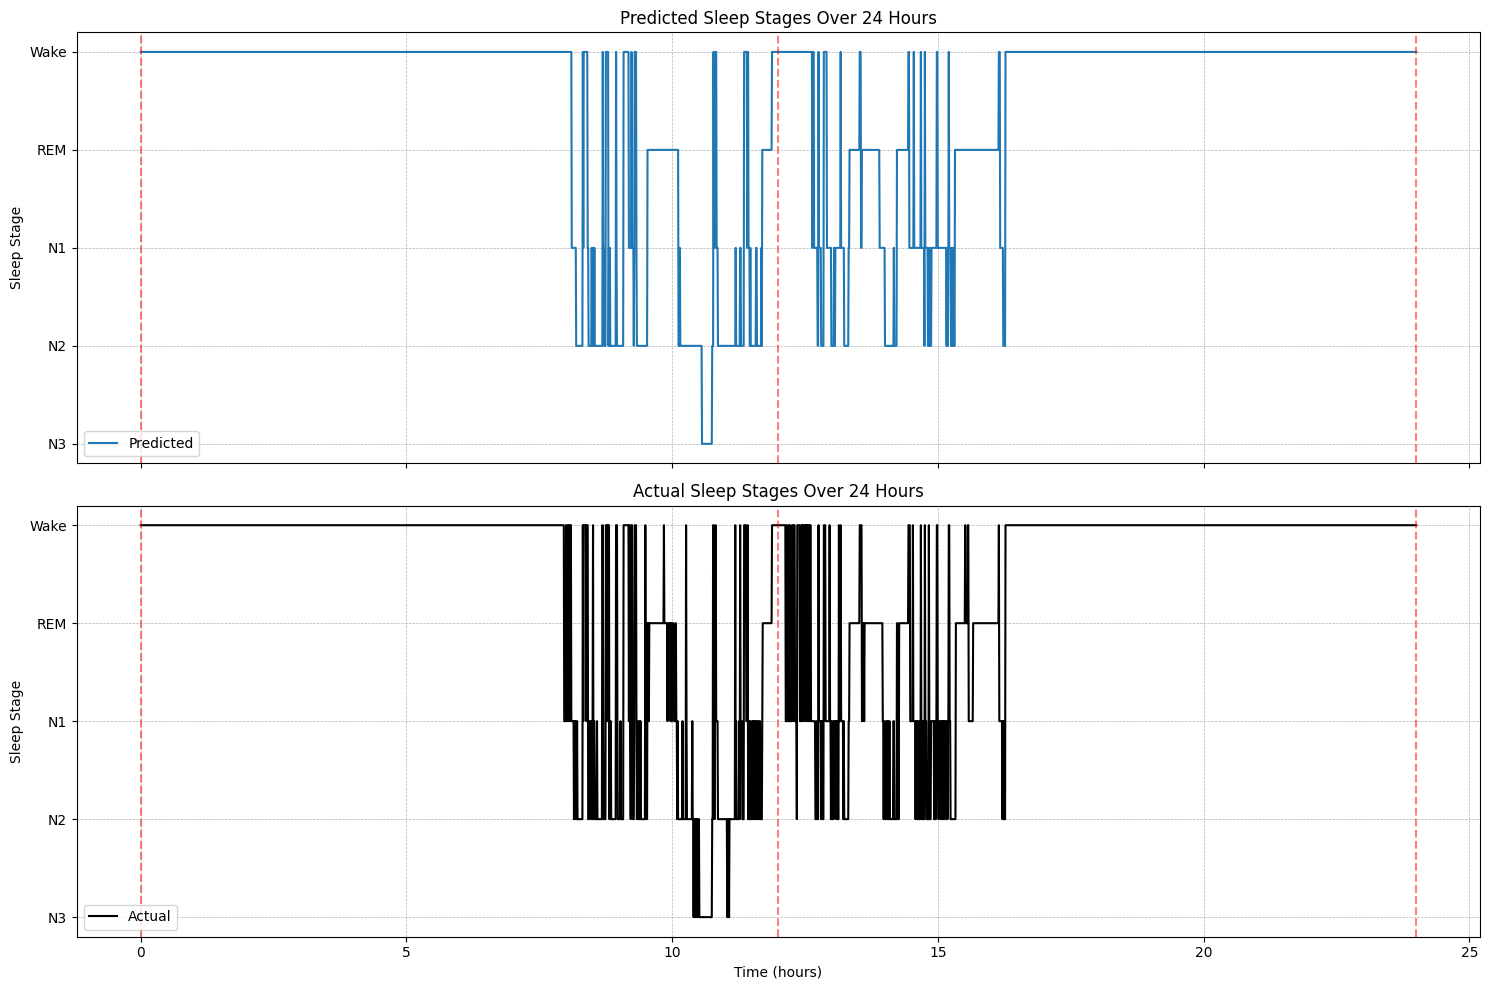

In [6]:
# Define sleep stages
sleep_stages = {4: 'Wake', 3: 'REM', 2: 'N1', 1: 'N2', 0: 'N3'}

# Load actual labels
labels_file = './data/labels.mat'
y_true = sio.loadmat(labels_file)['labels'].flatten() - 1  # Subtract 1 to match 0-4 encoding

# Ensure y_hat and y_true have the same length
min_length = min(len(y_hat), len(y_true))
y_hat = y_hat[:min_length]
y_true = y_true[:min_length]

# Calculate the number of epochs in 24 hours (assuming 30s epochs)
epochs_per_day = 24 * 60 * 2  # 24 hours * 60 minutes * 2 (30s epochs per minute)

# Calculate padding
total_padding = epochs_per_day - min_length
pad_start = total_padding // 2
pad_end = total_padding - pad_start

# Pad the predictions and actual data with 'Wake' (4) at both ends
padded_y_hat = np.pad(y_hat, (pad_start, pad_end), mode='constant', constant_values=4)
padded_y_true = np.pad(y_true, (pad_start, pad_end), mode='constant', constant_values=4)

# Create time axis in hours
time_axis = np.linspace(0, 24, epochs_per_day)

# Plot the predicted and actual sleep stages
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

# Predicted sleep stages
ax1.plot(time_axis, padded_y_hat, label='Predicted')
ax1.set_yticks([0, 1, 2, 3, 4])
ax1.set_yticklabels([sleep_stages[i] for i in [0, 1, 2, 3, 4]])
ax1.set_ylabel('Sleep Stage')
ax1.set_title('Predicted Sleep Stages Over 24 Hours')
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
ax1.legend()

# Actual sleep stages
ax2.plot(time_axis, padded_y_true, label='Actual', color='black')
ax2.set_yticks([0, 1, 2, 3, 4])
ax2.set_yticklabels([sleep_stages[i] for i in [0, 1, 2, 3, 4]])
ax2.set_xlabel('Time (hours)')
ax2.set_ylabel('Sleep Stage')
ax2.set_title('Actual Sleep Stages Over 24 Hours')
ax2.grid(True, which='both', linestyle='--', linewidth=0.5)
ax2.legend()

# Add vertical lines for midnight and noon on both subplots
for ax in [ax1, ax2]:
    ax.axvline(x=0, color='r', linestyle='--', alpha=0.5)
    ax.axvline(x=12, color='r', linestyle='--', alpha=0.5)
    ax.axvline(x=24, color='r', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

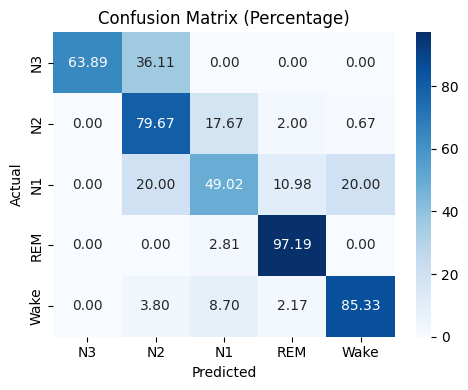


Classification Report:
              precision    recall  f1-score   support

          N3       1.00      0.64      0.78        36
          N2       0.77      0.80      0.78       300
          N1       0.62      0.49      0.55       255
         REM       0.86      0.97      0.91       249
        Wake       0.75      0.85      0.80       184

    accuracy                           0.77      1024
   macro avg       0.80      0.75      0.76      1024
weighted avg       0.76      0.77      0.76      1024



In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(y_true, y_hat)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=[sleep_stages[i] for i in range(5)],
            yticklabels=[sleep_stages[i] for i in range(5)])
plt.title('Confusion Matrix (Percentage)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Print classification report
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(y_true, y_hat, 
                            target_names=[sleep_stages[i] for i in range(5)]))